In [1]:
import pandas as pd

# Загрузка данных
df = pd.read_csv('data/fake_news_dataset.csv')

# Основные характеристики
print(f"Размер датасета: {df.shape}")
print(f"\nРаспределение классов:\n{df['label'].value_counts()}")
print(f"\nПропуски в данных:\n{df.isnull().sum()}")


Размер датасета: (20000, 7)

Распределение классов:
label
fake    10056
real     9944
Name: count, dtype: int64

Пропуски в данных:
title          0
text           0
date           0
source      1000
author      1000
category       0
label          0
dtype: int64


In [2]:
df['source'].fillna('Unknown Source', inplace=True)
df['author'].fillna('Anonymous author', inplace=True)

C:\Users\akaku\AppData\Local\Temp\ipykernel_6100\3495324563.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['source'].fillna('Unknown Source', inplace=True)
C:\Users\akaku\AppData\Local\Temp\ipykernel_6100\3495324563.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [3]:

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Ограничиваем число авторов
top_authors = df['author'].value_counts().head(200).index #.head(50)
df['author_limited'] = df['author'].apply(lambda x: x if x in top_authors else 'Other')

# Аналогично для source
top_sources = df['source'].value_counts().index
df['source_limited'] = df['source'].apply(lambda x: x if x in top_sources else 'Other')

# One-hot для ограниченных категорий
cat_cols_limited = ['author_limited', 'source_limited', 'category']

X_cat_limited = encoder.fit_transform(df[cat_cols_limited])

cat_feature_names = encoder.get_feature_names_out(cat_cols_limited)
X_cat_df = pd.DataFrame(X_cat_limited, columns=cat_feature_names)
X_cat_df.head()

,author_limited_Alexander Hill,author_limited_Amanda Hernandez,author_limited_Amanda Smith,author_limited_Andrew Anderson,author_limited_Andrew Miller,author_limited_Andrew Perez,author_limited_Andrew Smith,author_limited_Anna Peterson,author_limited_Anonymous author,author_limited_Anthony Jones,...,source_limited_Reuters,source_limited_The Guardian,source_limited_Unknown Source,category_Business,category_Entertainment,category_Health,category_Politics,category_Science,category_Sports,category_Technology
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление URL, email, спецсимволов
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Токенизация и удаление стоп-слов
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

# Применение очистки
df['cleaned_text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akaku\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Учёт униграмм и биграмм
    min_df=2,  # Минимум 2 документа на слово
    max_df=0.95  # Максимум 95% документов на слово
)

X_bow = bow_vectorizer.fit_transform(df['cleaned_text'])

In [6]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True  # log(1 + tf)
)

X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [7]:
from gensim.models import Word2Vec
import numpy as np

# Токенизация
sentences = [text.split() for text in df['cleaned_text']]

# Обучение модели
w2v_model = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=0  # CBOW
)

# Функция для получения вектора документа
def doc_vector(doc, model, vector_size=100):
    words = doc.split()
    vec = np.zeros(vector_size)
    n_words = 0
    for word in words:
        if word in model.wv:
            vec += model.wv[word]
            n_words += 1
    if n_words > 0:
        vec /= n_words
    return vec

# Векторизация всего корпуса
X_w2v = np.array([doc_vector(text, w2v_model) for text in df['cleaned_text']])


In [8]:

# Для разреженных матриц (BoW/TF-IDF)
from scipy.sparse import hstack
X_bow_combined = hstack([X_bow, X_cat_df.values])  
X_tfidf_combined = hstack([X_tfidf, X_cat_df.values])  

# Для плотных матриц (Word2Vec)
import numpy as np
X_w2v_combined = np.hstack([X_w2v, X_cat_df.values])

In [9]:
from sklearn.model_selection import train_test_split

y = df['label'].map({'real': 0, 'fake': 1})  # Кодирование меток

# Разделение для каждого метода векторизации
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42, stratify=y
)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)
X_train_w2v, X_test_w2v, _, _ = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42, stratify=y
)

X_train_bow_combined, X_test_bow_combined, _, _ = train_test_split(
    X_bow_combined, y, test_size=0.2, random_state=42, stratify=y
)
X_train_tfidf_combined, X_test_tfidf_combined, _, _ = train_test_split(
    X_tfidf_combined, y, test_size=0.2, random_state=42, stratify=y
)
X_train_w2v_combined, X_test_w2v_combined, _, _ = train_test_split(
    X_w2v_combined, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Модели для сравнения
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42)
}

# Словарь для хранения результатов
results = {}

In [11]:
for name, model in models.items():
    # BoW
    model.fit(X_train_bow, y_train)
    pred_bow = model.predict(X_test_bow)
    
    # TF-IDF
    model.fit(X_train_tfidf, y_train)
    pred_tfidf = model.predict(X_test_tfidf)
    
    # Word2Vec
    model.fit(X_train_w2v, y_train)
    pred_w2v = model.predict(X_test_w2v)

    # BoW
    model.fit(X_train_bow_combined, y_train)
    pred_bow_combined = model.predict(X_test_bow_combined)
    
    # TF-IDF
    model.fit(X_train_tfidf_combined, y_train)
    pred_tfidf_combined = model.predict(X_test_tfidf_combined)
    
    # Word2Vec
    model.fit(X_train_w2v_combined, y_train)
    pred_w2v_combined = model.predict(X_test_w2v_combined)
    
    # Сохранение результатов
    results[f'{name} (BoW)'] = {
        'Accuracy': accuracy_score(y_test, pred_bow),
        'Precision': precision_score(y_test, pred_bow),
        'Recall': recall_score(y_test, pred_bow),
        'F1': f1_score(y_test, pred_bow)
    }
    results[f'{name} (TF-IDF)'] = {
        'Accuracy': accuracy_score(y_test, pred_tfidf),
        'Precision': precision_score(y_test, pred_tfidf),
        'Recall': recall_score(y_test, pred_tfidf),
        'F1': f1_score(y_test, pred_tfidf)
    }
    results[f'{name} (Word2Vec)'] = {
        'Accuracy': accuracy_score(y_test, pred_w2v),
        'Precision': precision_score(y_test, pred_w2v),
        'Recall': recall_score(y_test, pred_w2v),
        'F1': f1_score(y_test, pred_w2v)
    }
    results[f'{name} (BoW_combined)'] = {
        'Accuracy': accuracy_score(y_test, pred_bow_combined),
        'Precision': precision_score(y_test, pred_bow_combined),
        'Recall': recall_score(y_test, pred_bow_combined),
        'F1': f1_score(y_test, pred_bow_combined)
    }
    results[f'{name} (TF-IDF_combined)'] = {
        'Accuracy': accuracy_score(y_test, pred_tfidf_combined),
        'Precision': precision_score(y_test, pred_tfidf_combined),
        'Recall': recall_score(y_test, pred_tfidf_combined),
        'F1': f1_score(y_test, pred_tfidf_combined)
    }
    results[f'{name} (Word2Vec_combined)'] = {
        'Accuracy': accuracy_score(y_test, pred_w2v_combined),
        'Precision': precision_score(y_test, pred_w2v_combined),
        'Recall': recall_score(y_test, pred_w2v_combined),
        'F1': f1_score(y_test, pred_w2v_combined)
    }

o:\Программирование\Repos\MLCourse\MLcourse\.venv311keras\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
o:\Программирование\Repos\MLCourse\MLcourse\.venv311keras\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https:/

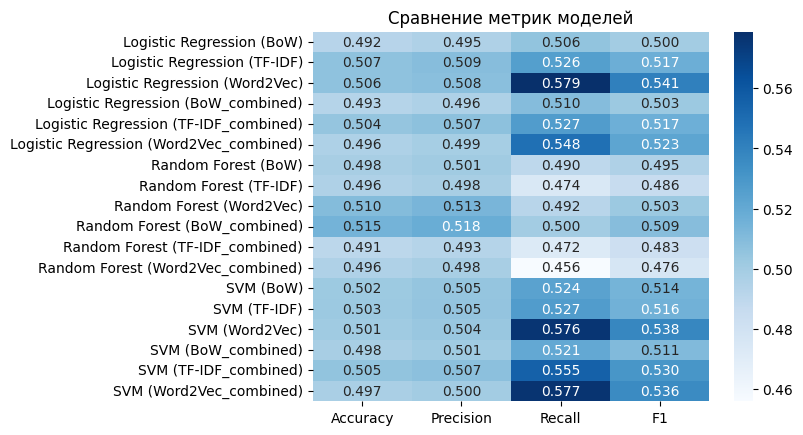

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results).T
sns.heatmap(results_df, annot=True, fmt='.3f', cmap='Blues')
plt.title('Сравнение метрик моделей')
plt.show()
